# Мини-проект по теме "Ядерные функции"

## ПОСТАНОВКА ЗАДАЧИ

Определить качество вина. Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

**Структура ноутбука:**

1. [Импортируемые библиотеки](#1)

2. [Загрузка данных](#2)

3. [EDA](#3)

4. [Feature Engineering](#4)

5. [Data Preprocessing](#5)

6. [ Модель SVM](#6)

<h1  style="text-align: center" class="list-group-item list-group-item-action active">1. Импортируемые библиотеки</h1><a id = "1"></a>

In [66]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from feature_engine.outliers import Winsorizer
import feature_engine.transformation as vt

from sklearn.model_selection import train_test_split

from collections import Counter

%matplotlib inline

# Ignoring Unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

<h1  style="text-align: center" class="list-group-item list-group-item-action active">2. Загрузка данных</h1><a id = "2"></a>

In [35]:
train = pd.read_csv('./winequality-red.csv', sep=';', low_memory=False)

In [36]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


В нашем датасете 1599 значений. Пропущенных значений нет.

<h1  style="text-align: center" class="list-group-item list-group-item-action active">3. EDA</h1><a id = "3"></a>

Посмотрим на количество встречающихся значений по всем признакам

In [38]:
train.nunique().sort_values()

quality                   6
free sulfur dioxide      60
alcohol                  65
citric acid              80
pH                       89
residual sugar           91
fixed acidity            96
sulphates                96
volatile acidity        143
total sulfur dioxide    144
chlorides               153
density                 436
dtype: int64

In [39]:
train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Посмотрим на графики распределения признаков.

In [40]:
# Function to create a histogram, and a boxplot and scatter plot.
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()

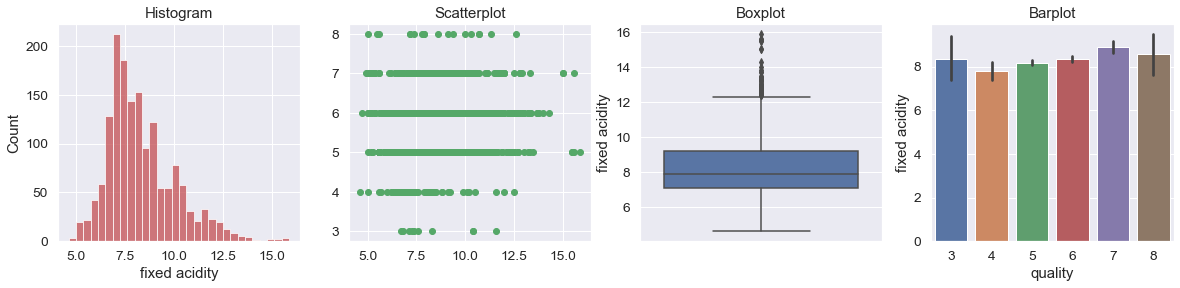

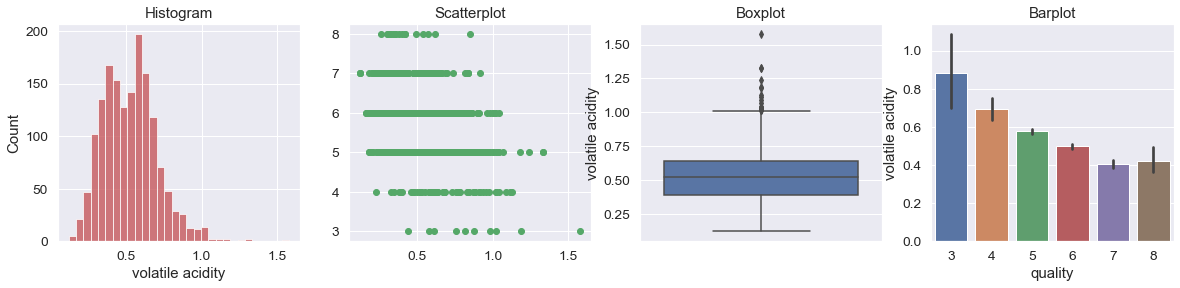

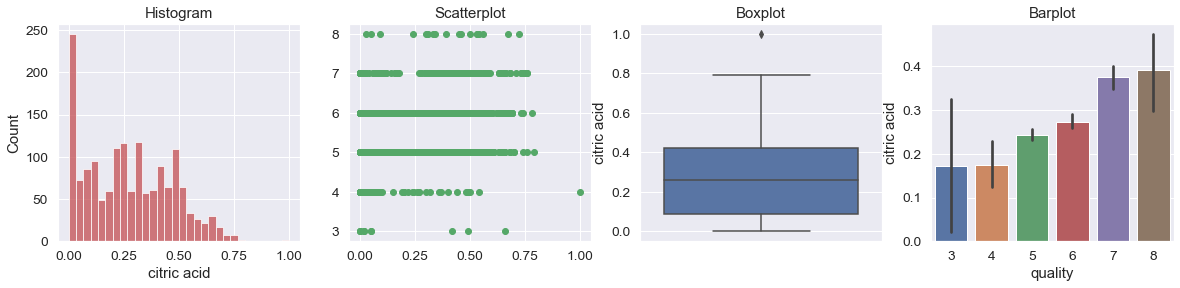

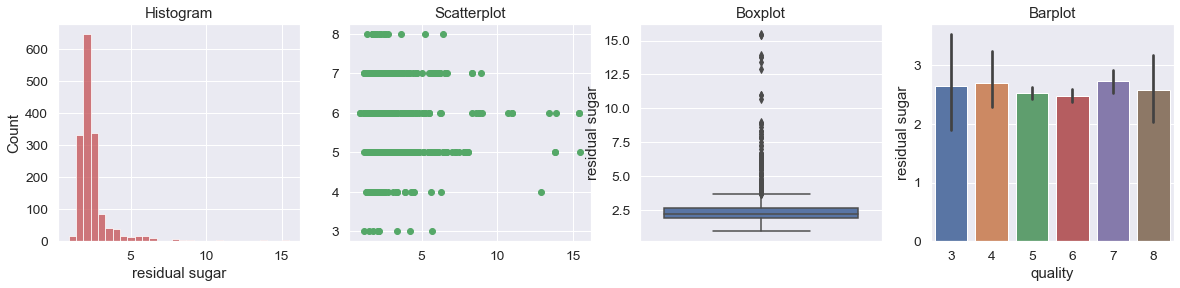

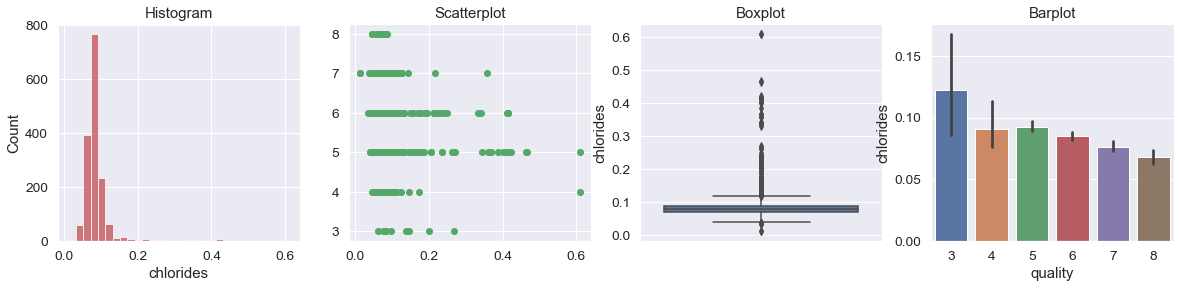

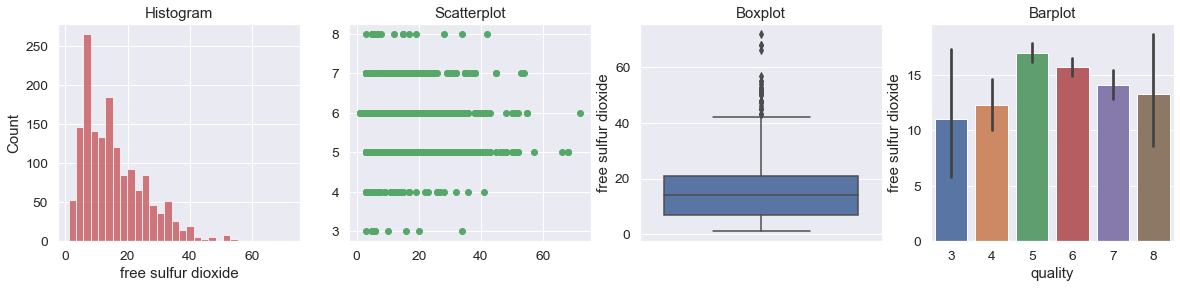

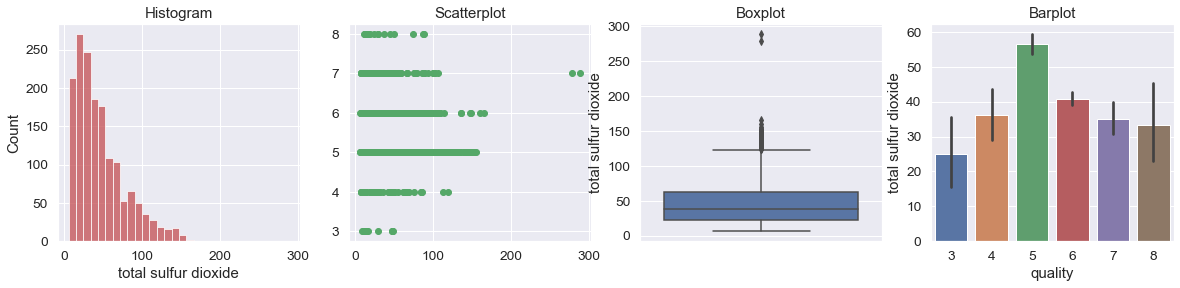

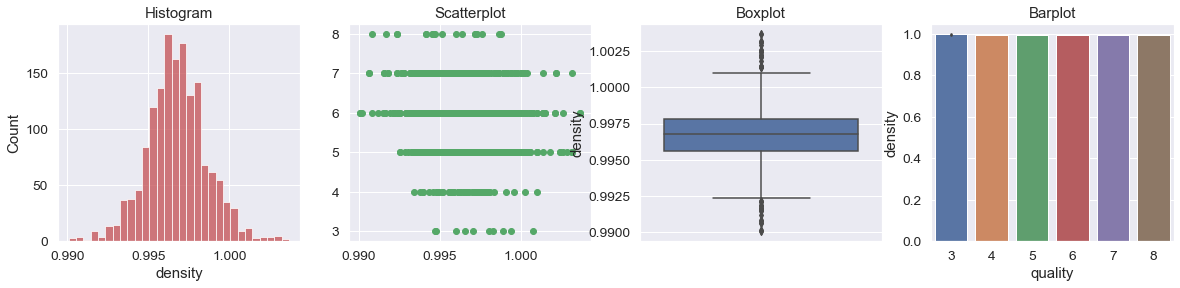

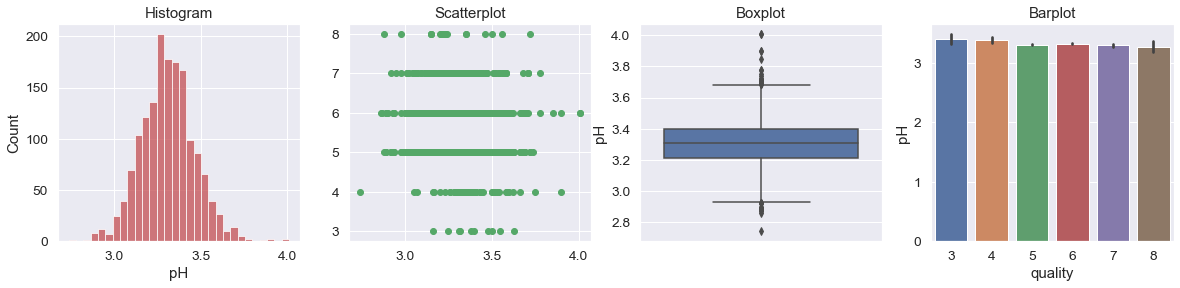

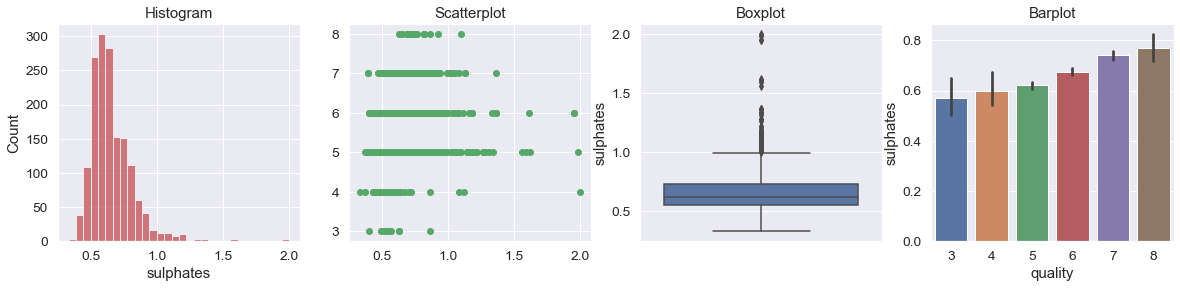

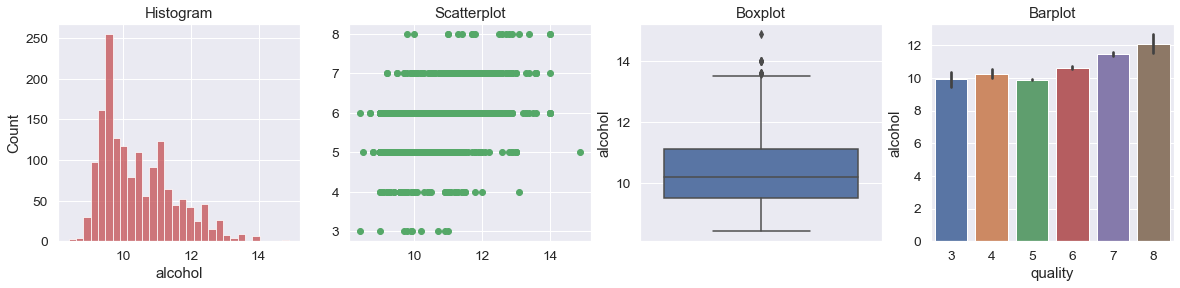

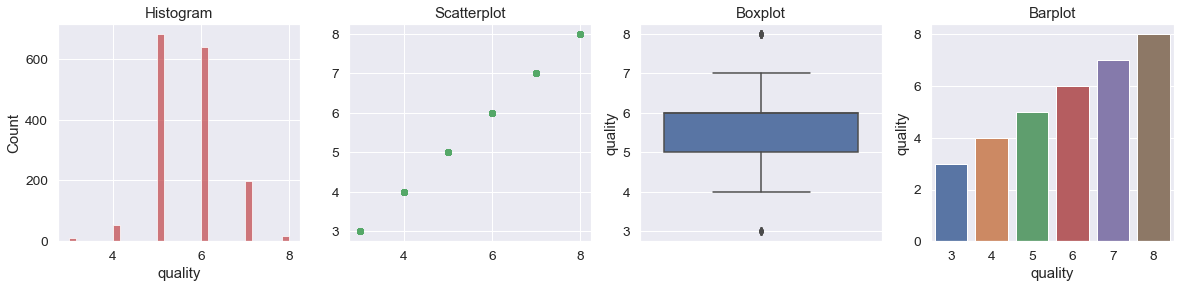

In [41]:
for variable in train:
    diagnostic_plots(train,variable,'quality')

Мы можем видеть асимметрию переменных и выбросы практически в каждом признаке.

Столбцы **pH** и **density** имеют нормальное распределение.

Остальные переменные имеют асимметрию вправо.

В нашем наборе данных большинство характеристик имеют выбросы.

Посмотрим на корреляцию признаков.

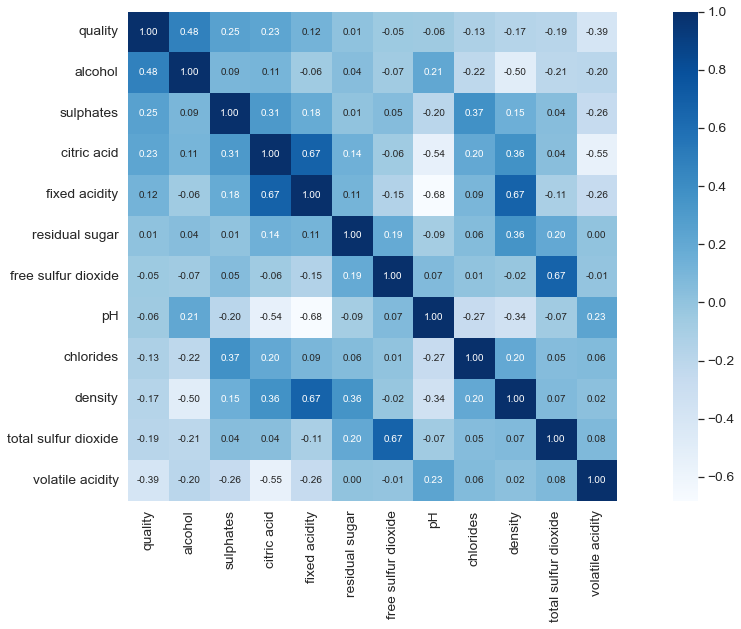

In [42]:
corr = train.corr()
plt.figure(figsize=(20, 9))
k = 12 #number of variables for heatmap
cols = corr.nlargest(k, 'quality')['quality'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap="Blues")
plt.show()

Мы видим, что наблюдается сильная положительная корреляции между следующими парами признаков:   
    1. **density** и **fixed acidity**  
    2. **total sulfur dioxide** и **free sulfur dioxide**  
    3. **fixed acidity** и **citric acid**  
    
Признаки **residual sugar**, **free sulfur dioxide** и **pH** почти не связаны с **quality**.   

Поскольку корреляция близка к нулю, мы можем сделать вывод, что между этими предикторами нет линейной зависимости.

Самую высокую корреляцию с **quality** имеет признак **alcohol**.

<h1  style="text-align: center" class="list-group-item list-group-item-action active">4. Feature Engineering</h1><a id = "4"></a>

### ВЫБРОСЫ

In [43]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

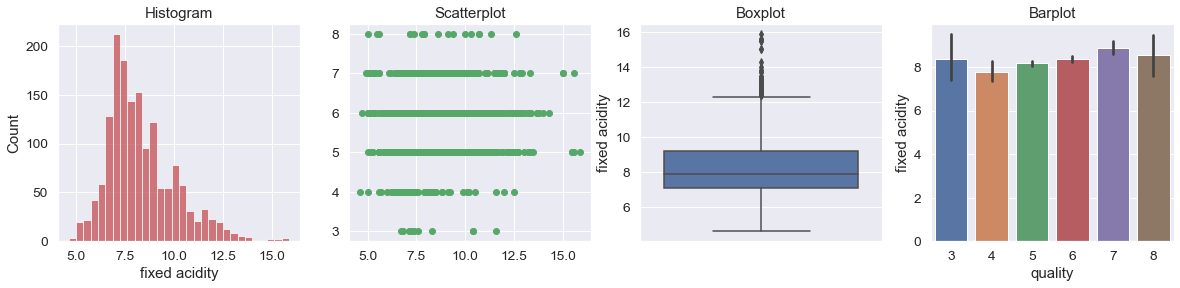

In [44]:
diagnostic_plots(train,'fixed acidity','quality')

In [45]:
train.loc[detect_outliers(train,train.columns[:-1])]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
353,13.5,0.530,0.79,4.8,0.120,23.0,77.0,1.00180,3.18,0.77,13.0,5
364,12.8,0.615,0.66,5.8,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
366,12.8,0.615,0.66,5.8,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
374,14.0,0.410,0.63,3.8,0.089,6.0,47.0,1.00140,3.01,0.81,10.8,6
442,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7
538,12.9,0.350,0.49,5.8,0.066,5.0,35.0,1.00140,3.20,0.66,12.0,7
554,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
555,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
557,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
559,13.0,0.470,0.49,4.3,0.085,6.0,47.0,1.00210,3.30,0.68,12.7,6


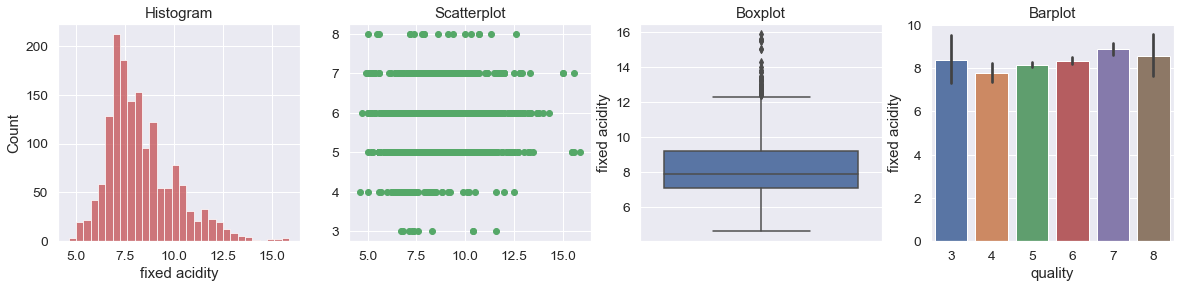

In [46]:
diagnostic_plots(train,'fixed acidity','quality')

Мы видели, что многие признаки имеют ассиметрию в распределениях. Избавимся от нее с помощью нормализации.

In [47]:
cols = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
       'sulphates', 'alcohol']

In [49]:
lt = vt.LogTransformer(variables = cols)

lt.fit(train)

LogTransformer(variables=['fixed acidity', 'volatile acidity', 'residual sugar',
                          'chlorides', 'free sulfur dioxide',
                          'total sulfur dioxide', 'sulphates', 'alcohol'])

In [50]:
train = lt.transform(train)

Сделаем целевую переменную категориальной ('bad wine': quality < 6.5 и 'good wine': quality > 6.5).

In [51]:
train.quality = train.quality.apply(
            lambda x: 'good wine' if x >= 6.5 
            else 'bad wine')

<h1  style="text-align: center" class="list-group-item list-group-item-action active">5. Data Preprocessing</h1><a id = "5"></a>

Закодируем нашу целевую переменную.

In [52]:
encoder = LabelEncoder()

In [53]:
train['quality'] = encoder.fit_transform(train['quality'])

In [54]:
train['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [55]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710,0
1,2.054124,-0.127833,0.00,0.955511,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,2.282382,0
2,2.054124,-0.274437,0.04,0.832909,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,2.282382,0
3,2.415914,-1.272966,0.56,0.641854,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,2.282382,0
4,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710,0


In [56]:
X = train.drop(['quality'], axis = 1)
y = train['quality']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<h1  style="text-align: center" class="list-group-item list-group-item-action active">6. Модель SVM</h1><a id = "6"></a>

Построим SVC с параметрами по умолчанию.

In [59]:
classifier = SVC(random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Посчитаем Accuracy.

In [60]:
accuracies = cross_val_score(estimator = classifier, X = X_train,
                             y = y_train, cv = 10)
accuracies.mean().round(2)

0.89

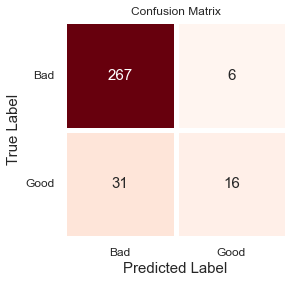

In [61]:
cm = confusion_matrix(y_test, y_pred)

df1 = pd.DataFrame(columns=["Bad","Good"], index= ["Bad","Good"], data= cm )

f,ax = plt.subplots(figsize=(4,4))

sns.heatmap(df1, annot=True,cmap="Reds", fmt= '.0f',ax=ax,linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

Теперь попробуем подобрать параметры с помощью GridSearchCV.

In [62]:
parameters = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

In [63]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [64]:
best_parameters

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [65]:
best_accuracy.round(2)

0.91

**Выводы**

Различие в оценках модели при подборе параметров по сетке составило 2%.
Можно еще было повысить качество модели, найдя взаимосвязи между признаками и создав новые признаки из них (очень мало времени для проработки темы, очень много статей по этой теме).
Также судя по confusion_matrix у нас наблюдается явный дисбаланс классов после кодирования целевой переменной. Можно было попробовать решить эту проблему с помощью SMOTE.